In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from glob import glob
import xesmf as xe
import cmocean
import datetime
import sys
sys.path.append('../')
from utils import *
from numerics import *
from load import *

---
### CHECK SPINUP

In [2]:
status = pd.read_csv('data/crocod1_status.out',index_col=1, sep=' ')[::180]
status = status[np.array([type(x)==float for x in status.index])]
status.index = [pd.Timedelta(days=d)+pd.to_datetime('1949-12-31') for d in status.index]
status

/tmp/ipykernel_7970/1563909060.py:1: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  status = pd.read_csv('data/crocod1_status.out',index_col=1, sep=' ')[::180]


,STEP,KINETIC_ENERGY,POTENTIAL_ENERGY,TOTAL_ENRGY,NET_VOLUME
2000-01-01 00:00:00.000000000,0,0.002471,46.753173,46.755645,1.444504e+140
2000-01-01 01:00:00.287999744,180,0.137705,46.594591,46.732296,1.444593e+140
2000-01-01 01:59:59.712000256,360,0.239384,46.29589,46.535274,1.444578e+140
2000-01-01 03:00:00.000000000,540,0.250293,46.004663,46.254956,1.444573e+140
2000-01-01 04:00:00.287999744,720,0.259251,45.64017,45.899421,1.444579e+140
...,...,...,...,...,...
2000-09-30 19:47:20.256000000,1182922,0.002634,47.866234,47.868868,1.444450e+140
2000-09-30 20:47:19.679999744,1183102,0.002628,47.866891,47.869518,1.444450e+140
2000-09-30 21:47:19.968000000,1183282,0.002622,47.867598,47.87022,1.444450e+140
2000-09-30 22:47:20.256000000,1183462,0.002616,47.868345,47.870961,1.444450e+140


(0.001, 0.007)

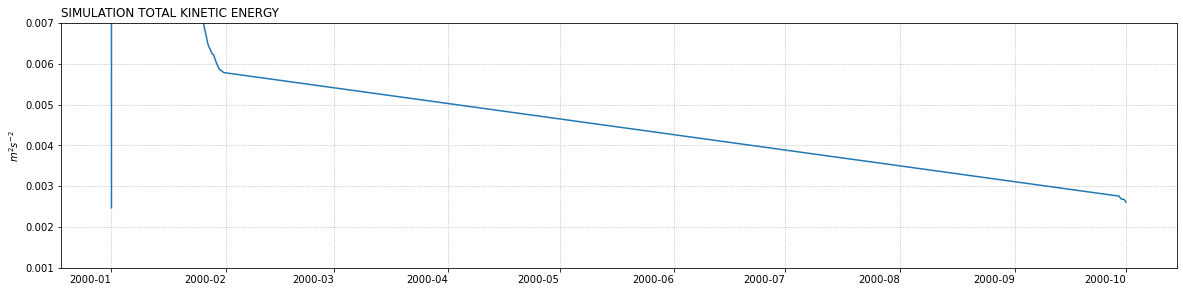

In [10]:
status.KINETIC_ENERGY.plot(figsize=(20,5))
ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.YearLocator())
ax.grid(True, ls=":")
ax.set_title('SIMULATION TOTAL KINETIC ENERGY', loc='left')
ax.set_ylabel('$m^2s^{-2}$')
ax.tick_params(axis='x', rotation=0)
ax.set_ylim(0.001,0.007)

---

### SEA SURFACE TEMPERATURE

In [62]:
ostia = xr.open_dataset('~/storage/SST_CLIMATOLOGY_OSTIA.nc').analysed_sst
ostia = ostia.sel(lon=slice(-72.5,-71.1),lat=slice(-32.7,-28.19))

In [63]:
son = (ostia.dayofyear>=244)&(ostia.dayofyear<=334)
djf = (ostia.dayofyear<=365)&(ostia.dayofyear>=335)|((ostia.dayofyear>=1)&(ostia.dayofyear<=59))
mam = (ostia.dayofyear>=60)&(ostia.dayofyear<=151)
jja = (ostia.dayofyear>=152)&(ostia.dayofyear<=243)

ostia_season = [ostia.where(x).mean('dayofyear') for x in [djf, mam, jja, son]]
ostia_season = xr.concat(ostia_season,'season')
ostia_season.coords['season']=['DJF','MAM','JJA','SON']

In [12]:
paths = sorted(glob('data/DESALADORAS_RUND1/crocod1_avg_*'))[12:]
control = xr.open_mfdataset(paths, parallel=True)

sst = control.temp.isel(s_rho=-1).compute()
sst = sst.where(sst>0)
sst = fix_crocotime(sst, YORIG='1949-12-31 00:00:00')

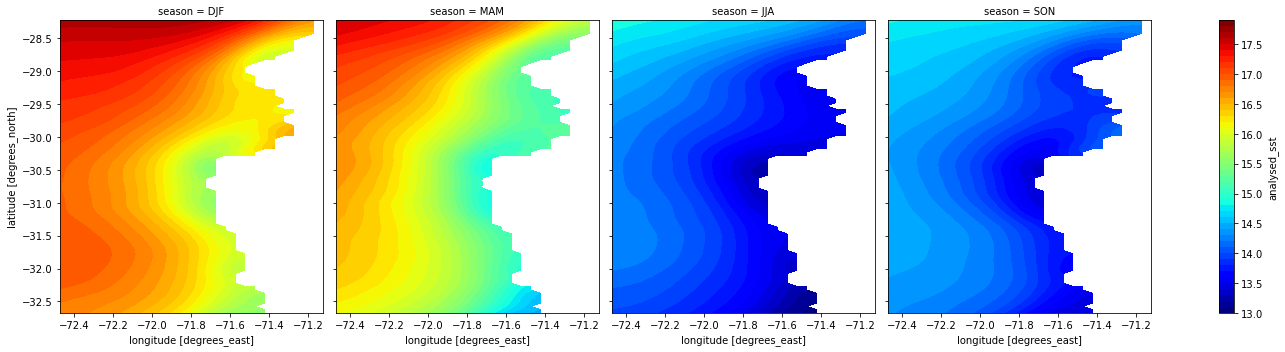

In [67]:
ostia_season.plot.contourf(col='season', figsize=(20,5), cmap='jet', levels=np.arange(13,18,0.1))

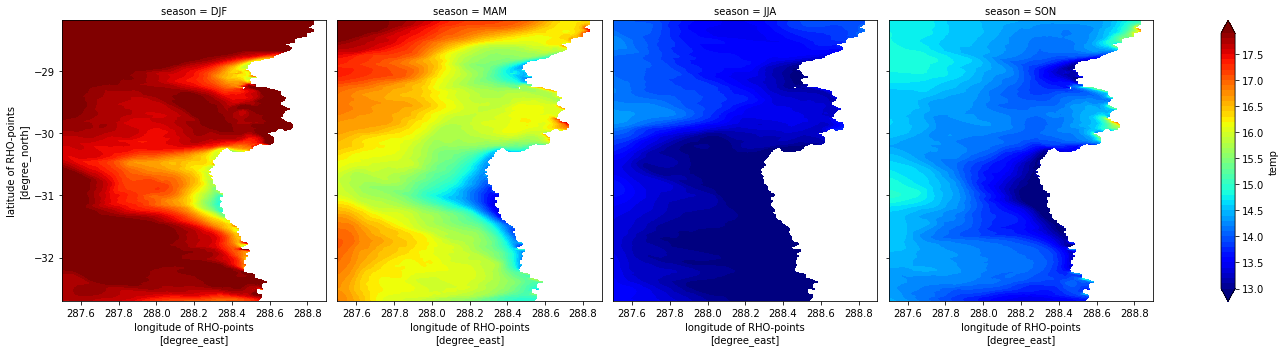

In [68]:
sst.groupby('time.season').mean().sel(season=['DJF','MAM','JJA','SON']).plot.contourf(col='season', figsize=(20,5), cmap='jet', levels=np.arange(13,18,0.1), x='lon_rho', y='lat_rho')

In [51]:
sstcroco_coquimbo = sst.sel(xi_rho=124, eta_rho=349, method='nearest').to_series()
sstcroco_coquimbo.index = sstcroco_coquimbo.index - pd.Timedelta(hours=12, seconds=10)
sst_coquimbo      = pd.read_csv('~/storage/TSM_Coquimbo.csv', index_col=0, parse_dates=True)
sst_coquimbo      = sst_coquimbo['TSM[°C]'].interpolate().resample('d').mean().loc["2001"]

Text(0.0, 1.0, 'MBIAS: -0.267 ; RMSE: 1.093 ; r: 0.906')

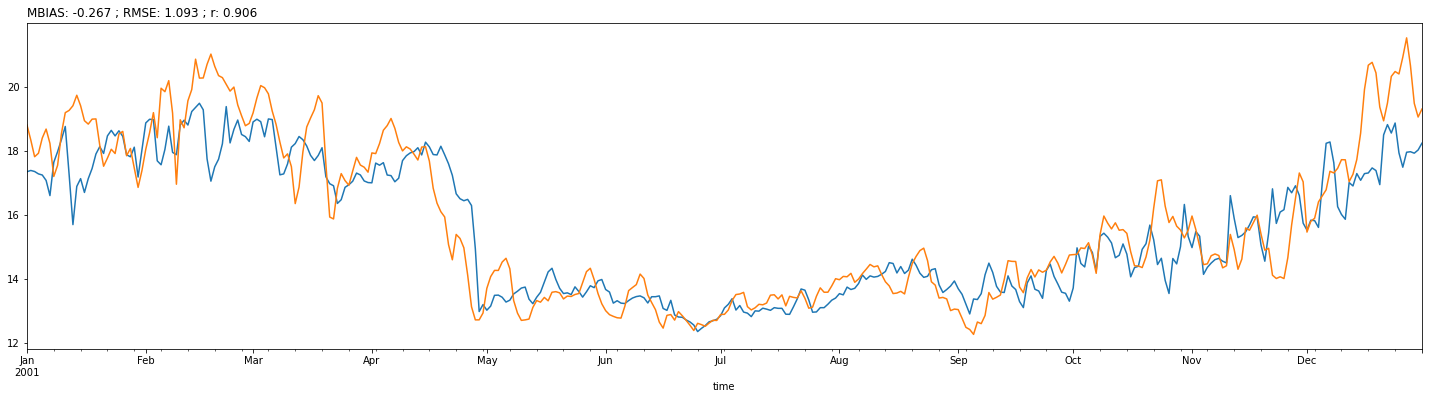

In [52]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(1,1, figsize=(25,6))
sst_coquimbo.plot(ax=ax)
sstcroco_coquimbo.plot(ax=ax)
ax.set_title('MBIAS: {:.3f} ; RMSE: {:.3f} ; r: {:.3f}'.format((sst_coquimbo-sstcroco_coquimbo).mean(),
                                                            ((sst_coquimbo-sstcroco_coquimbo)**2).mean()**0.5,
                                                            pearsonr(sst_coquimbo.interpolate(), sstcroco_coquimbo)[0]),
             loc='left')

Text(0.0, 1.0, 'MBIAS: 0.004 ; RMSE: 0.749 ; r: 0.094')

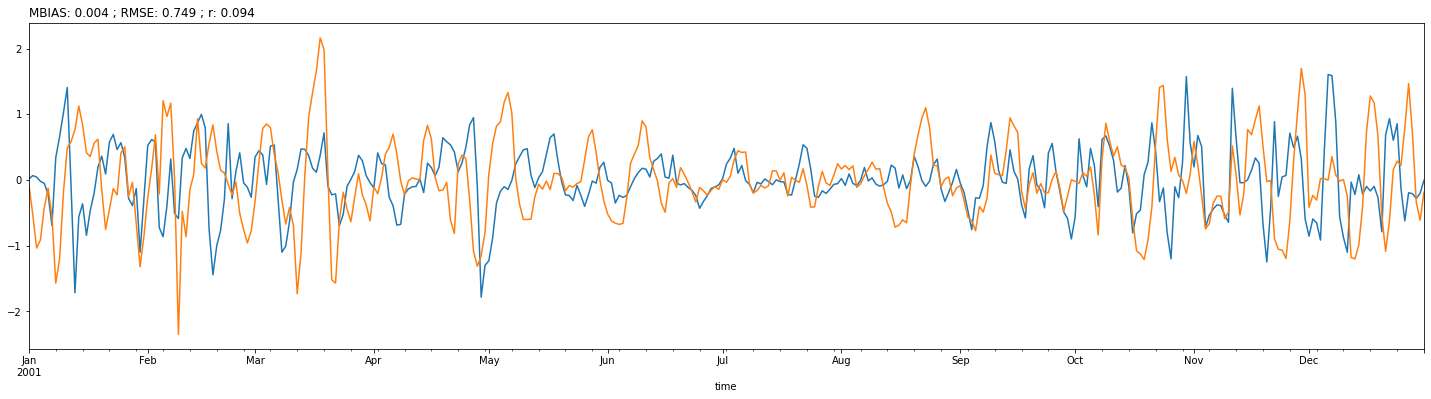

In [53]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(1,1, figsize=(25,6))
pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index).plot(ax=ax)
pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index).plot(ax=ax)
ax.set_title('MBIAS: {:.3f} ; RMSE: {:.3f} ; r: {:.3f}'.format((pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index)-pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index)).mean(),
                                                            ((pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index)-pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index))**2).mean()**0.5,
                                                            pearsonr(pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index).interpolate(), pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index))[0]),
             loc='left')